<a href="https://colab.research.google.com/github/gabriellaaileen/ADL/blob/main/UTS%20ADL/UTS_ADL_XNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import cv2

#import Keras sub-modules
from keras.models import Model #functional API for Keras (best for greater flexibility)
from keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense #'main' layers
from keras.layers import BatchNormalization, Dropout #regulartisation layers
from keras.layers import Activation
from keras.optimizers import * #import all optimisers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger #callbacks for model performance analysis
from keras.metrics import categorical_accuracy #metrics for model performance
from keras import backend as K #gives backend functionality
from keras import losses #imports pre-defined loss functions
from keras.models import load_model #allows pre-trained models to be called back

##**PREDIKSI DENGAN DATA BAWAAN**

In [2]:
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1Wel_XsyE7HcEq0TkZWI61GABO4jOtj9C',
                                    dest_path='./dataset.hdf5')
gdd.download_file_from_google_drive(file_id='1cePD5E-T9mr5W0xPGuzEnUt8Glpvn23U',
                                    dest_path='./model.h5')

In [3]:
hdf5_path = "./dataset.hdf5" ## this is our h5 file containing training and testing data
dataset = h5py.File(hdf5_path , 'r')

classes = 3
test_images = dataset['test_img'][:]
print(test_images.shape)
no_images, height, width, channels = test_images.shape


print(dataset['test_label'][:].shape)
test_labels =dataset['test_label'][:].reshape(-1,height*width, classes )
print(test_labels.shape)
dataset.close()

(22, 200, 200, 1)
(22, 40000, 3)
(22, 40000, 3)


In [3]:
model = load_model("./model.h5")

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 200, 200, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 200, 200, 64  256        ['conv2d_1[0][0]']               
 rmalization)                   )                                                           

**Modifikasi Program**

* Mengubah dari batch ukuran 1 menjadi custom (ukuran batch tidak boleh lebih dari 22)

masukkan batch size: 6
Berikut adalah data test yang digunakan: 


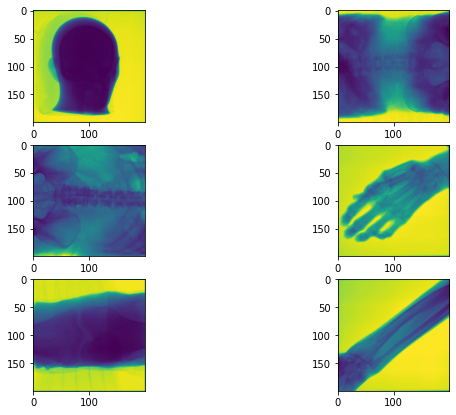

In [5]:
batch_size=int(input("masukkan batch size: "))
if batch_size > 22:
  print("maaf, ukuran batch melebihi ukuran dataset")
else:
  fig = plt.figure(figsize=(10, 7))
  print("Berikut adalah data test yang digunakan: ")
  for i in range(batch_size):
    fig.add_subplot(3, 2, i+1)
    plt.imshow(test_images[i].reshape(200,200))

* Menampilkan hasil prediksi dalam batch custom

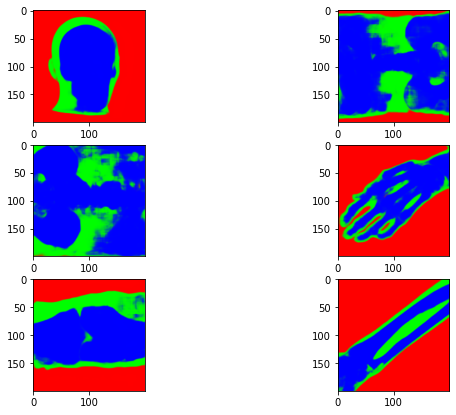

In [6]:
batch_size=int(input("masukkan batch size: "))
if batch_size > 22:
  print("maaf, ukuran batch melebihi ukuran dataset")
else:
  testing_image=np.empty([batch_size,200,200,1])
  for i in range(batch_size):
    testing_image[i]=test_images[i]
  testing_image=testing_image.reshape((batch_size,200,200,1))
  
  prediction2 = model.predict(testing_image)
  prediction2 = prediction2.reshape((batch_size,200,200,3))

  fig = plt.figure(figsize=(10, 7))
  for i in range(batch_size):
    fig.add_subplot(3, 2, i+1)
    plt.imshow(prediction2[i])

##**PREDIKSI DENGAN DATA DARI KAGGLE**

**Load data dari Kaggle**

In [7]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"mendrofaa","key":"71cbe0b6310e6e2134984f289b929c1f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/rsna-bone-age

100% 9.28G/9.29G [03:13<00:00, 49.5MB/s]
100% 9.29G/9.29G [03:13<00:00, 51.6MB/s]


In [ ]:
!ls

 00000013_005_gs.png   kaggle.json		   rsna-bone-age.zip
 dataset.hdf5	       model.h5			   sample_data
 input		       opera_house_grayscale.jpg   sample.zip
'kaggle (1).json'      opera-house.jpg


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('rsna-bone-age.zip', 'r')
zip_ref.extractall('bone_age')
zip_ref.close()

**Preprocessing Data**
1. Mengecek ukuran dan mode gambar (RGB atau Grayscale)
2. Meresize gambar sesuai ukuran input layer (200x200)
3. Mengubah gambar menjadi format array sebagai input
4. Mereshape array menjadi (200, 200, 1)

**Contoh Preprocessing dan Prediksi 1 Data**

In [4]:
!pip install Pillow

In [5]:
# check Pillow version number
import PIL
print('Pillow Version:', PIL.__version__)

Pillow Version: 7.1.2


In [14]:
# load and show an image with Pillow
from PIL import Image
# load the image
image = Image.open('/content/bone_age/boneage-training-dataset/boneage-training-dataset/10000.png')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# show the image
image.show()

PNG
L
(1334, 1653)


In [ ]:
gs_image = image.resize((200,200))
# save in jpeg format
gs_image.save('10000_gs.png')
# load the image again and show it
image2 = Image.open('10000_gs.png')
# show the image
image2.show()

float32
(200, 200)


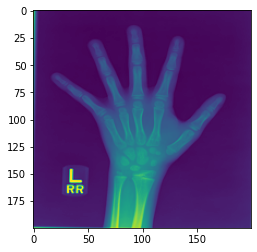

In [29]:
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data2 = image.imread('10000_gs.png')
# summarize shape of the pixel array
print(data2.dtype)
print(data2.shape)
# display the array of pixels as an image
pyplot.imshow(data2)
pyplot.show()

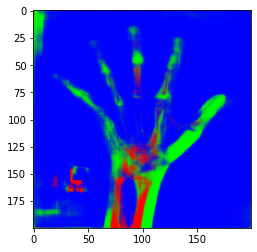

In [ ]:
testing_image = data2.reshape((1,200,200,1))
prediction = model.predict(testing_image)

#the prediction is a flattened array and so must be reshaped.
#there are 3 channels as we are actually outputting the probability map over all 3 classes.
prediction = prediction.reshape((200,200,3))
plt.imshow(prediction)

**Preprocessing Data dalam Batch**

In [58]:
#setting the path to the directory containing the pics
image_path = '/content/bone_age/boneage-test-dataset/boneage-test-dataset'

In [77]:
name = os.listdir(image_path)
name.remove('.ipynb_checkpoints')

In [121]:
batch_size2=int(input("Masukkan batch size: "))

Masukkan batch size: 5


In [123]:
input_arr=[]
for img in name[0:batch_size2]:
  image = tf.keras.preprocessing.image.load_img(path=os.path.join(image_path,img),color_mode="grayscale",target_size=(200,200))
  pic = tf.keras.preprocessing.image.img_to_array(image)
  input_arr.append(pic.reshape((1,200,200,1)))
  #
  #input_arr = np.array([input_arr])  # Convert single image to a batch.

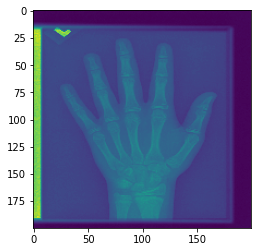

In [124]:
input_arr = np.asarray(input_arr)
input_arr = input_arr.reshape(batch_size2,200,200,1)
pyplot.imshow(input_arr[0].reshape(200,200))
pyplot.show()

In [125]:
predictions = model.predict(input_arr)

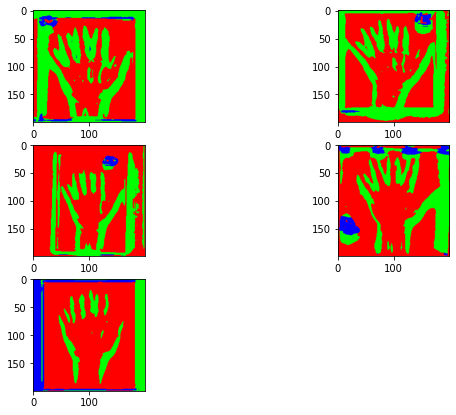

In [126]:
predictions = predictions.reshape((batch_size2,200,200,3))

fig = plt.figure(figsize=(10, 7))
for i in range(batch_size):
   fig.add_subplot(3, 2, i+1)
   plt.imshow(predictions[i])